In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from numba import jit
from tqdm import tqdm
from scipy.integrate import quad

from psiam_delay_utils import simulate_psiam
from psiam_delay_utils import rho_A_t_fn, cum_A_t_fn
from psiam_delay_utils import rho_E_t_fn
from psiam_delay_utils import P_small_t_btn_x1_x2, rho_E_minus_small_t_NORM_fn

# Generate data

In [6]:
V_A = 1; theta_A = 2; 
V_E = 1.2; theta_E = 2
Z_E = 0
t_stim = 0.5
t_A_aff = 20e-3
t_E_aff = 30e-3
t_motor = 50e-3


N_sim = 10000
choices = np.zeros((N_sim, 1)); RTs = np.zeros((N_sim, 1)); is_act_resp = np.zeros((N_sim, 1))


def simulate_wrapper(V_A, theta_A, V_E, theta_E, Z_E, t_stim):
    return simulate_psiam(V_A, theta_A, V_E, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor)

results = Parallel(n_jobs=-1)(delayed(simulate_wrapper)(V_A, theta_A, V_E, theta_E, Z_E, t_stim) for _ in range(N_sim))

choices, RTs, is_act_resp = zip(*results)
choices = np.array(choices).reshape(-1, 1)
RTs = np.array(RTs).reshape(-1, 1)
is_act_resp = np.array(is_act_resp).reshape(-1, 1)

print(f'Num of act resp = {is_act_resp.sum()}/{N_sim}')
print(f'Number of aborts = {(RTs < t_stim).sum()}')

psiam_data = {'choices': choices, 'RTs': RTs, 'is_act_resp': is_act_resp, 'V_A': V_A, 'theta_A': theta_A, 
              'V_E': V_E, 'theta_E': theta_E, 't_stim': t_stim, 'Z_E': Z_E,
              't_A_aff': t_A_aff, 't_E_aff': t_E_aff, 't_motor': t_motor
              }


with open('psiam_data_delay_1.pkl', 'wb') as f: # _1 for t_stim = 0, _2 for non t_stim = 0.3
    pickle.dump(psiam_data, f)

Num of act resp = 5976/10000
Number of aborts = 147


# Read data

In [5]:
with open('psiam_data_delay_1.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']
t_A_aff = psiam_data['t_A_aff']
t_E_aff = psiam_data['t_E_aff']
t_motor = psiam_data['t_motor']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid].flatten()

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act].flatten()

RTs = RTs.flatten()


choice_up_idx = np.where(choices == 1)[0]
RTs_up = RTs[choice_up_idx]

choice_down_idx = np.where(choices == -1)[0]
RTs_down = RTs[choice_down_idx]



print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f"t start is {t_stim}")
print(f"t_A_aff: {t_A_aff}, t_E_aff: {t_E_aff}, t_motor: {t_motor}")


V_A: 1
theta_A: 2
V_E: 1.2
theta_E: 2
Num of AI process: 5976/10000
t start is 0.5
t_A_aff: 0.02, t_E_aff: 0.03, t_motor: 0.05


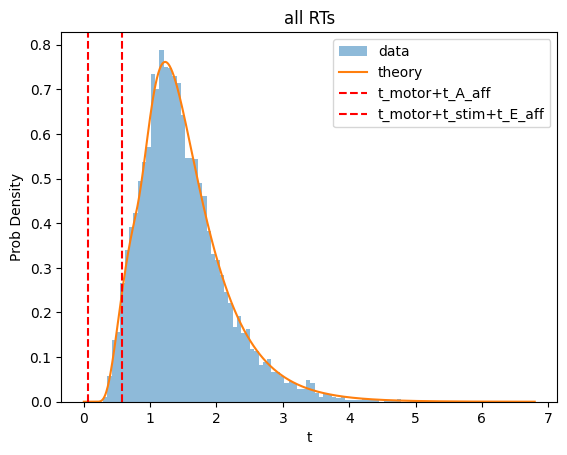

In [19]:
t_pts = np.linspace(0.001, max(RTs), 1000)
K_max = 10
P_A = [rho_A_t_fn(t, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
C_E = [quad(rho_E_t_fn, 0, t, args=(V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor))[0] for t in t_pts]
P_E = [rho_E_t_fn(t, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); C_E = np.array(C_E); P_E = np.array(P_E); C_A = np.array(C_A)
P_all = P_A*(1-C_E) + P_E*(1-C_A)


plt.hist(RTs, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_all, label='theory');
plt.axvline(x=t_motor+t_A_aff, label='t_motor+t_A_aff', linestyle='--', color='r')
plt.axvline(x=t_stim+t_motor+t_E_aff, label='t_motor+t_stim+t_E_aff',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('all RTs');

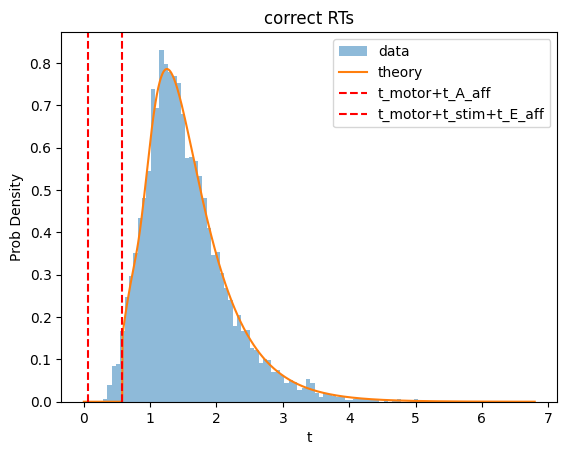

In [18]:
t_pts = np.linspace(0.001, max(RTs), 1000)
K_max = 10
P_A = [rho_A_t_fn(t, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_1_2 = [P_small_t_btn_x1_x2(1, 2, t, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]

P_E_plus = [rho_E_minus_small_t_NORM_fn(t, -V_E, theta_E, K_max, t_stim, -Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
norm_term = len(choice_up_idx)/len(RTs)

P_correct = (P_A*P_EA_btn_1_2 + P_E_plus*(1-C_A))/norm_term

plt.hist(RTs_up, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_correct, label='theory');
plt.axvline(x=t_motor+t_A_aff, label='t_motor+t_A_aff', linestyle='--', color='r')
plt.axvline(x=t_stim+t_motor+t_E_aff, label='t_motor+t_stim+t_E_aff',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('correct RTs');

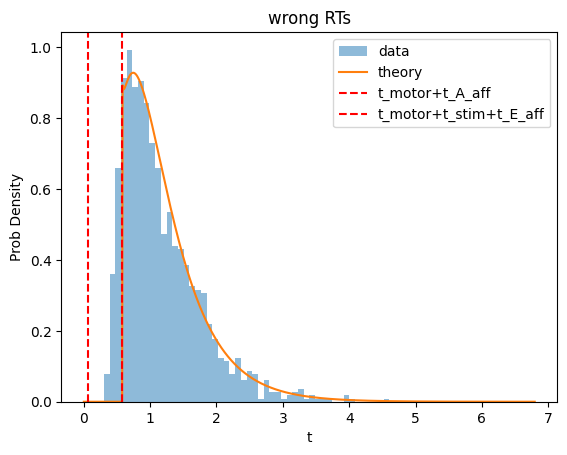

In [17]:
t_pts = np.linspace(0.001, max(RTs), 1000)
K_max = 10
P_A = [rho_A_t_fn(t, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]
P_EA_btn_0_1 = [P_small_t_btn_x1_x2(0, 1, t, V_E, theta_E, Z_E, K_max, t_stim, t_E_aff, t_motor) for t in t_pts]

P_E_minus = [rho_E_minus_small_t_NORM_fn(t, V_E, theta_E, K_max, t_stim, Z_E, t_E_aff, t_motor) for t in t_pts]
C_A = [cum_A_t_fn(t, V_A, theta_A, t_A_aff, t_motor) for t in t_pts]

P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
norm_term = len(choice_down_idx)/len(RTs)

P_wrong = (P_A*P_EA_btn_0_1 + P_E_minus*(1-C_A))/norm_term

plt.hist(RTs_down, bins=50, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_wrong, label='theory');
plt.axvline(x=t_motor+t_A_aff, label='t_motor+t_A_aff', linestyle='--', color='r')
plt.axvline(x=t_stim+t_motor+t_E_aff, label='t_motor+t_stim+t_E_aff',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('wrong RTs');

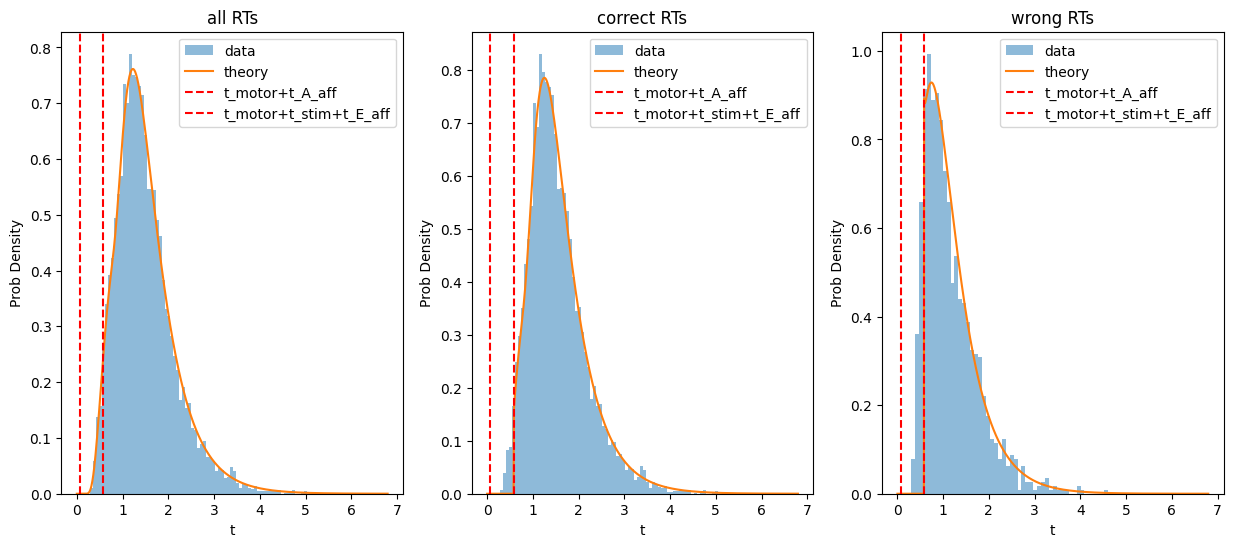

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(1,3,1)
plt.hist(RTs, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_all, label='theory');
plt.axvline(x=t_motor+t_A_aff, label='t_motor+t_A_aff', linestyle='--', color='r')
plt.axvline(x=t_stim+t_motor+t_E_aff, label='t_motor+t_stim+t_E_aff',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('all RTs');


plt.subplot(1,3,2)
plt.hist(RTs_up, bins=100, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_correct, label='theory');
plt.axvline(x=t_motor+t_A_aff, label='t_motor+t_A_aff', linestyle='--', color='r')
plt.axvline(x=t_stim+t_motor+t_E_aff, label='t_motor+t_stim+t_E_aff',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('correct RTs');


plt.subplot(1,3,3)
plt.hist(RTs_down, bins=50, alpha=0.5, label='data', density=True);
plt.plot(t_pts, P_wrong, label='theory');
plt.axvline(x=t_motor+t_A_aff, label='t_motor+t_A_aff', linestyle='--', color='r')
plt.axvline(x=t_stim+t_motor+t_E_aff, label='t_motor+t_stim+t_E_aff',linestyle='--', color='r')
plt.legend();
plt.xlabel('t'); plt.ylabel('Prob Density');plt.title('wrong RTs');